In [1]:
%pip install evaluate

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install optuna


Note: you may need to restart the kernel to use updated packages.


In [1]:
import gc
import torch
import pandas as pd
import ast  # for list-like labels, if needed
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import (
    DebertaTokenizer,
    DebertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from evaluate import load
import numpy as np
import optuna  # Using optuna for hyperparameter optimization

In [2]:
# Clean up GPU memory
gc.collect()
torch.cuda.empty_cache()

In [3]:
import re

In [4]:
# -------------------------------
# Data Preparation and Tokenization
# -------------------------------

# Define column names and load datasets
columns = ['par_id', 'art_id', 'keyword', 'country_code', 'text', 'label']
df_texts = pd.read_csv("dontpatronizeme_pcl.tsv", sep="\t", header=None, names=columns)
df_labels = pd.read_csv("train_semeval_parids-labels.csv")

# Ensure the IDs are strings for merging
df_texts["par_id"] = df_texts["par_id"].astype(str)
df_labels["par_id"] = df_labels["par_id"].astype(str)

# Drop unnecessary label column from df_labels and create binary labels in df_texts
df_labels = df_labels.drop(columns=["label"])
df_texts["binary_label"] = df_texts["label"].apply(lambda x: 1 if x >= 2 else 0)
df_texts = df_texts.drop(columns=["label"])

# Merge datasets on paragraph ID and rename the binary label to "label"
df = df_labels.merge(df_texts, on="par_id", how="left")
df.rename(columns={"binary_label": "label"}, inplace=True)
df = df.dropna(subset=["text", "label"])  # Drop rows with missing data

# def clean_text(text):
#     text = re.sub(r"\s+", " ", text)  # Remove extra spaces
#     text = re.sub(r"[^a-zA-Z0-9.,!?'\"]", " ", text)  # Remove special characters
#     return text.strip()

# # Ensure text column has no NaN values before applying text cleaning
# df["text"] = df["text"].astype(str).apply(clean_text)

def clean_text(text):
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text)
    # Optionally remove only very specific noise
    # For example, remove non-ASCII characters:
    # text = re.sub(r"[^\x00-\x7F]+", " ", text)
    return text.strip()
df["text"] = df["text"].astype(str).apply(clean_text)
print("Preprocessing and balancing complete!")

# Initialize the tokenizer and model
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")
model = DebertaForSequenceClassification.from_pretrained(
    "microsoft/deberta-base", num_labels=2, ignore_mismatched_sizes=True
)

# Tokenization function
def tokenize_function(text):
    return tokenizer(text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

# Tokenize the texts and stack tensors
df["tokenized"] = df["text"].apply(lambda x: tokenize_function(x))
input_ids = torch.cat([t["input_ids"] for t in df["tokenized"]], dim=0)
attention_masks = torch.cat([t["attention_mask"] for t in df["tokenized"]], dim=0)
labels = torch.tensor(df["label"].values, dtype=torch.long)

Preprocessing and balancing complete!


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# -------------------------------
# Create Dataset and Sampler
# -------------------------------

class PCLDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx],
        }

# Split data into training and validation sets using indices
indices = list(range(len(df)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_ids, val_ids = input_ids[train_idx], input_ids[val_idx]
train_masks, val_masks = attention_masks[train_idx], attention_masks[val_idx]
train_labels, val_labels = labels[train_idx], labels[val_idx]

train_dataset = PCLDataset(train_ids, train_masks, train_labels)
val_dataset = PCLDataset(val_ids, val_masks, val_labels)


In [6]:
# -------------------------------
# Define a Custom Trainer with Weighted Sampling
# -------------------------------

class WeightedSamplerTrainer(Trainer):
    def get_train_dataloader(self):
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")
        # Compute class counts from the dataset labels
        labels_tensor = torch.tensor(self.train_dataset.labels)
        class_counts = torch.bincount(labels_tensor)
        class_weights = 1.0 / class_counts.float()
        sample_weights = class_weights[labels_tensor.numpy()]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(self.train_dataset), replacement=True)
        return DataLoader(
            self.train_dataset,
            batch_size=self.args.per_device_train_batch_size,
            sampler=sampler,
        )

In [7]:
# -------------------------------
# Define Metric Computation
# -------------------------------

def compute_metrics(eval_pred):
    """Computes Accuracy and F1 Score"""
    accuracy_metric = load("accuracy")
    f1_metric = load("f1")
    predictions = np.argmax(eval_pred.predictions, axis=1)
    references = eval_pred.label_ids
    accuracy_score = accuracy_metric.compute(predictions=predictions, references=references)
    f1_score = f1_metric.compute(predictions=predictions, references=references)
    return {"accuracy": accuracy_score["accuracy"], "f1": f1_score["f1"]}


In [10]:
# -------------------------------
# Define the Hyperparameter Tuning Objective with Early Stopping
# -------------------------------

def objective(trial):
    # Suggest hyperparameters (updated to use suggest_float with log=True)
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0, 0.3)

    # Update TrainingArguments with trial hyperparameters
    training_args = TrainingArguments(
       output_dir="./results",
       learning_rate=learning_rate,
       optim="adamw_torch",
       warmup_ratio=0.1,
       evaluation_strategy="epoch",
       save_strategy="no", # change to no
       per_device_train_batch_size=4,  # Reduce from 8 or 16 to 4 or even 2
       per_device_eval_batch_size=4,   # Match train batch size
       num_train_epochs=2,
       weight_decay=weight_decay,
       logging_dir="./logs",
       logging_steps=50,
       save_total_limit=2,
       lr_scheduler_type="linear",
       load_best_model_at_end=False,
       metric_for_best_model="f1",
       report_to="none",
       fp16=False,  # Enables mixed precision training (reduces memory usage)
       bf16=False,  # Keep this False unless on Ampere GPUs (A100, RTX 30xx)
   )


    # Initialize Trainer with early stopping callback
    trainer = WeightedSamplerTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train and evaluate the model
    trainer.train()
    eval_result = trainer.evaluate()

    # Use F1 score as the objective to maximize
    f1 = eval_result["eval_f1"]
    print(f"Trial completed with F1: {f1}")
    return f1

# -------------------------------
# Run Hyperparameter Tuning with Optuna
# -------------------------------

# Create a study that maximizes the F1 score
study = optuna.create_study(direction="maximize")
# Run the optimization for a fixed number of trials (e.g., 10)
study.optimize(objective, n_trials=4)

# Print the best hyperparameters found
print("Best hyperparameters:", study.best_trial.params)

[I 2025-02-25 16:57:31,774] A new study created in memory with name: no-name-e0e63cc4-7cc1-4fd5-a18d-977107562adc


/vol/bitbucket/lb124/DL_CW_2_lb124/.venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_668716/662171446.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(self.train_dataset.labels)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.226700,0.489274,0.894328,0.540260
2,0.055400,0.606412,0.891343,0.540404


[I 2025-02-25 18:01:50,809] Trial 0 finished with value: 0.5404040404040404 and parameters: {'learning_rate': 7.90341162920405e-06, 'weight_decay': 0.021977809081319234}. Best is trial 0 with value: 0.5404040404040404.


Trial completed with F1: 0.5404040404040404


/vol/bitbucket/lb124/DL_CW_2_lb124/.venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_668716/662171446.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(self.train_dataset.labels)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.367400,0.730222,0.561791,0.295585
2,0.580200,0.663923,0.703284,0.338216


[I 2025-02-25 19:06:10,252] Trial 1 finished with value: 0.3382157123834887 and parameters: {'learning_rate': 7.939719956157809e-05, 'weight_decay': 0.05057966835240424}. Best is trial 0 with value: 0.5404040404040404.


Trial completed with F1: 0.3382157123834887


/vol/bitbucket/lb124/DL_CW_2_lb124/.venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_668716/662171446.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(self.train_dataset.labels)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.474200,0.569416,0.785075,0.397993
2,0.672300,0.651439,0.756418,0.376147


[I 2025-02-25 20:10:29,732] Trial 2 finished with value: 0.3761467889908257 and parameters: {'learning_rate': 1.2519743196155877e-06, 'weight_decay': 0.0522838300580664}. Best is trial 0 with value: 0.5404040404040404.


Trial completed with F1: 0.3761467889908257


/vol/bitbucket/lb124/DL_CW_2_lb124/.venv/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_668716/662171446.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_tensor = torch.tensor(self.train_dataset.labels)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.386500,0.692036,0.789851,0.411371
2,0.551900,0.679311,0.785075,0.419355


[I 2025-02-25 21:14:56,530] Trial 3 finished with value: 0.41935483870967744 and parameters: {'learning_rate': 2.847099973065812e-06, 'weight_decay': 0.10457938142224618}. Best is trial 0 with value: 0.5404040404040404.


Trial completed with F1: 0.41935483870967744
Best hyperparameters: {'learning_rate': 7.90341162920405e-06, 'weight_decay': 0.021977809081319234}


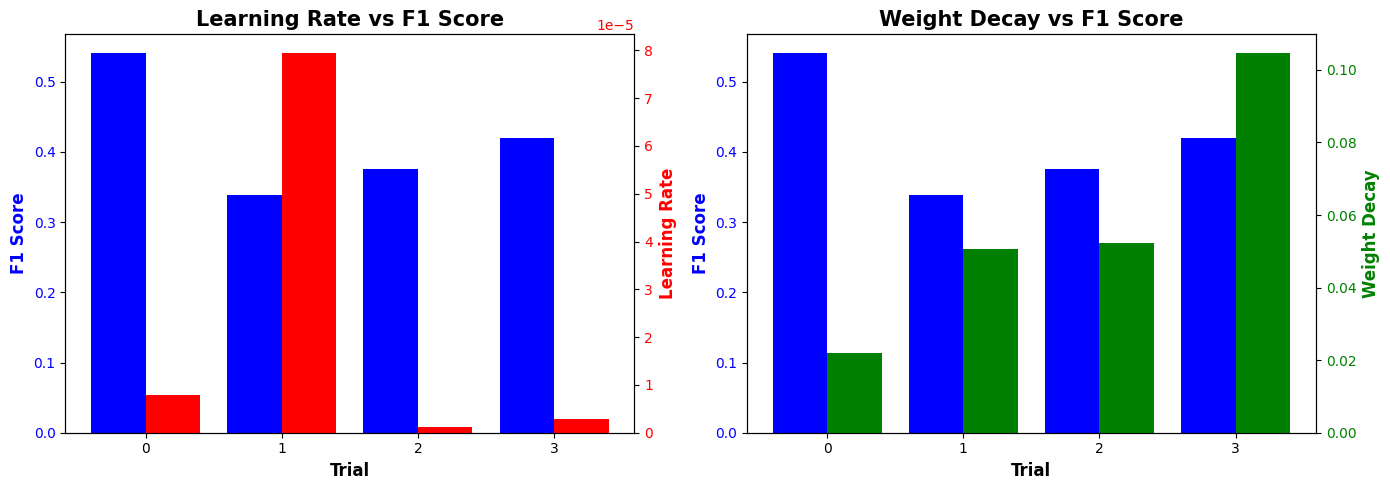

In [10]:
import matplotlib.pyplot as plt
import numpy as np
# Hardcoded results from your hyperparameter tuning
# Trials are 0, 1, 2, and 3 with corresponding F1 scores:
# plt.rcParams.update({'font.size': 14, 'font.weight': 'bold'})
trials = [0, 1, 2, 3]
f1_scores = [0.540404, 0.338216, 0.376147, 0.419355]

# Optionally, you can also record the learning rate and weight decay values for each trial:
learning_rates = [7.90341162920405e-06, 7.939719956157809e-05, 1.2519743196155877e-06, 2.847099973065812e-06]
weight_decays  = [0.021977809081319234, 0.05057966835240424, 0.0522838300580664, 0.10457938142224618]

# Positions and bar width for the grouped bars
x = np.arange(len(trials))
bar_width = 0.4

# Create a figure with two subplots side by side
fig, (ax_lr, ax_wd) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# ---------------------------
# Left Plot: Learning Rate vs. F1 Score
# ---------------------------
# Plot F1 score bars on primary axis (blue)
ax_lr.bar(x - bar_width/2, f1_scores, bar_width, color='blue', label='F1 Score')
ax_lr.set_xlabel('Trial', fontsize=12, fontweight='bold')
ax_lr.set_ylabel('F1 Score', color='blue', fontsize=12, fontweight='bold')
ax_lr.tick_params(axis='y', labelcolor='blue')
ax_lr.set_title('Learning Rate vs F1 Score', fontsize=15, fontweight='bold')
ax_lr.set_xticks(x)
ax_lr.set_xticklabels(trials)

# Twin axis for learning rate bars (red)
ax_lr2 = ax_lr.twinx()
ax_lr2.bar(x + bar_width/2, learning_rates, bar_width, color='red', label='Learning Rate')
ax_lr2.set_ylabel('Learning Rate', color='red', fontsize=12, fontweight='bold')
ax_lr2.tick_params(axis='y', labelcolor='red')

# ---------------------------
# Right Plot: Weight Decay vs. F1 Score
# ---------------------------
# Plot F1 score bars on primary axis (blue)
ax_wd.bar(x - bar_width/2, f1_scores, bar_width, color='blue', label='F1 Score')
ax_wd.set_xlabel('Trial', fontsize=12, fontweight='bold')
ax_wd.set_ylabel('F1 Score', color='blue', fontsize=12, fontweight='bold')
ax_wd.tick_params(axis='y', labelcolor='blue')
ax_wd.set_title('Weight Decay vs F1 Score', fontsize=15, fontweight='bold')
ax_wd.set_xticks(x)
ax_wd.set_xticklabels(trials)

# Twin axis for weight decay bars (green)
ax_wd2 = ax_wd.twinx()
ax_wd2.bar(x + bar_width/2, weight_decays, bar_width, color='green', label='Weight Decay')
ax_wd2.set_ylabel('Weight Decay', color='green', fontsize=12, fontweight='bold')
ax_wd2.tick_params(axis='y', labelcolor='green')

plt.tight_layout()
plt.show()
# Scale factor for learning rates to make them visible in the plot





**TEST WEIGHTED RANDOM SAMPLER WITH DEBERTA**

In [8]:

model = DebertaForSequenceClassification.from_pretrained("./deberta_WS_model")
tokenizer = DebertaTokenizer.from_pretrained("./deberta_WS_model")

In [9]:
columns = ['par_id', 'art_id', 'keyword', 'country_code', 'text', 'label']
def tokenize_function(text):
    return tokenizer(text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

df_dev = pd.read_csv("dev_semeval_parids-labels.csv")
df_texts = pd.read_csv("dontpatronizeme_pcl.tsv", sep="\t", header=None, names=columns)

df_dev["par_id"] = df_dev["par_id"].astype(str)
df_texts["par_id"] = df_texts["par_id"].astype(str)

df_dev = df_dev.drop(columns=["label"])
df_texts["binary_label"] = df_texts["label"].apply(lambda x: 1 if x >= 2 else 0)
df_texts = df_texts.drop(columns=["label"])

# Merge datasets on paragraph ID and rename the binary label to "label"
df_dev = df_dev.merge(df_texts, on="par_id", how="left")
df_dev.rename(columns={"binary_label": "label"}, inplace=True)
df_dev = df_dev.dropna(subset=["text", "label"])  # Drop rows with missing data

df_dev = df_dev.dropna(subset=["text", "label"])
def clean_text(text):
    # text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    # text = re.sub(r"[^a-zA-Z0-9.,!?'\"]", " ", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# Ensure text column has no NaN values before applying text cleaning
df_dev["text"] = df_dev["text"].astype(str).apply(clean_text)
def tokenize_function(text):
    return tokenizer(text, truncation=True, padding="max_length", max_length=512, return_tensors="pt")

# Tokenize the texts and stack tensors
df_dev["tokenized"] = df_dev["text"].apply(lambda x: tokenize_function(x))

dev_input_ids = torch.cat([t["input_ids"] for t in df_dev["tokenized"]], dim=0)
dev_attention_masks = torch.cat([t["attention_mask"] for t in df_dev["tokenized"]], dim=0)
dev_labels = torch.tensor(df_dev["label"].values, dtype=torch.long)

df_dev["tokenized"] = df_dev["text"].apply(lambda x: tokenize_function(x))
class PCLDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx],
        }

# Create a Dataset instance (assuming you have a PCLDataset defined similarly)
dev_dataset = PCLDataset(dev_input_ids, dev_attention_masks, dev_labels)


In [ ]:
final_training_args = TrainingArguments(
       output_dir="./results",
       learning_rate=9.468961305919929e-06,
       optim="adamw_torch",
       warmup_ratio=0.1,
       evaluation_strategy="epoch",
       save_strategy="no", # change to no
       per_device_train_batch_size=4,  # Reduce from 8 or 16 to 4 or even 2
       per_device_eval_batch_size=4,   # Match train batch size
       num_train_epochs=2,
       weight_decay=0.03430359963348227,
       logging_dir="./logs",
       logging_steps=50,
       save_total_limit=2,
       lr_scheduler_type="linear",
       load_best_model_at_end=False,
       metric_for_best_model="f1",
       report_to="none",
       fp16=False,  # Enables mixed precision training (reduces memory usage)
       bf16=False,  # Keep this False unless on Ampere GPUs (A100, RTX 30xx)
   )

final_trainer = WeightedSamplerTrainer(
    model=model,
    args=final_training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics

)

final_results = final_trainer.evaluate()
print("Final evaluation results:", final_results)